In [1]:
from imprint.nb_util import setup_nb
setup_nb()

import jax
import jax.numpy as jnp
import numpy as np
import scipy
import matplotlib.pyplot as plt
import imprint as ip
import imprint.bound.normal as normal
from imprint.models.ztest import ZTest1D
from imprint.models.ttest_adaptive import TTest1DAda
from imprint.models.basket import BayesianBasket

2023-03-31 12:51:13,147 - imprint - DEBUG 
Enabling 64-bit floats in JAX.


In [2]:
mu_0 = 0  # fixed threshold for null hypothesis
theta_min = [0, -0.5]  # minimum for theta
theta_max = [0, -0.5]  # maximum for theta
n_init = 10  # initial number of Gaussian draws
n_samples_per_interim = 10  # number of Gaussian draws per interim
n_interims = 5  # number of interims
n_gridpts = [1, 1]  # number of grid-points along each direction
alpha = 0.025  # target nominal level
n_sims = 100000  # number of simulations
eff_size_thresh = 0.1

In [3]:
grid = ip.cartesian_grid(
    theta_min=theta_min,
    theta_max=theta_max,
    n=n_gridpts,
    null_hypos=[ip.hypo("theta0 <= 1e-12"), ip.hypo("theta1 <= 0")],
)

model = TTest1DAda(
    seed=0,
    max_K=n_sims,
    n_init=n_init,
    n_samples_per_interim=n_samples_per_interim,
    n_interims=n_interims,
    mu0=mu_0,
    eff_size_thresh=eff_size_thresh,
)

In [4]:
Ts = -model.sim_batch(0, n_sims, grid.get_theta(), grid.get_null_truth())[0]
Ts_pruned = Ts[~jnp.isinf(Ts)]

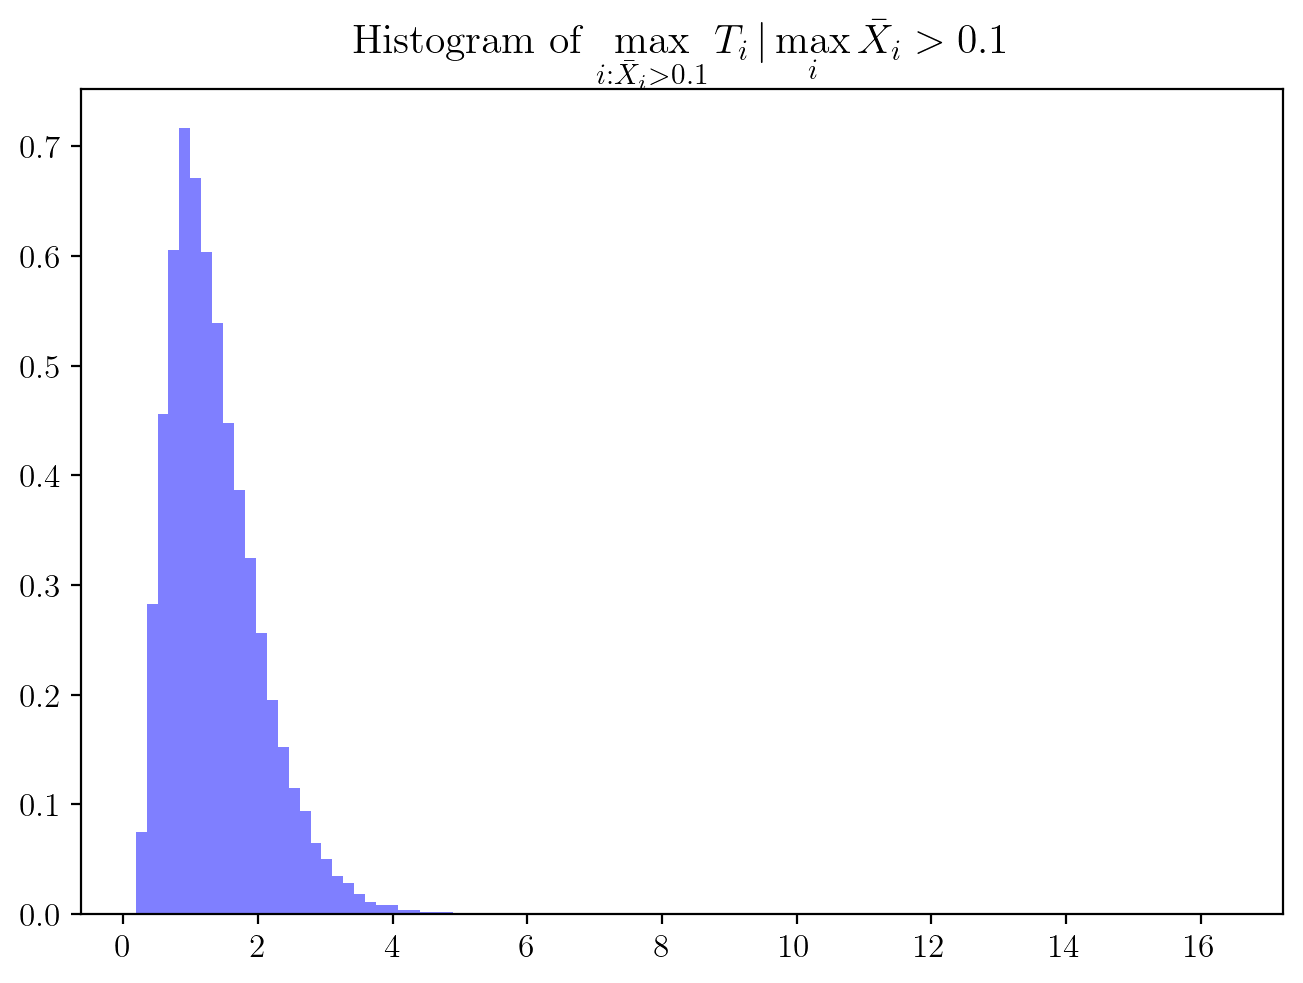

In [5]:
fig = plt.figure(constrained_layout=True)
plt.hist(Ts_pruned, density=True, bins=100, color='blue', alpha=0.5)
plt.title(f"Histogram of $\max\limits_{{i: \\bar{{X}}_i > {eff_size_thresh}}} T_i \, | \max\limits_{{i}} \\bar{{X}}_i > {eff_size_thresh}$")
plt.savefig("figures/introduction_att_hist.pdf", bbox_inches='tight')
plt.show()

In [6]:
def validate_2d(theta_min, theta_max, n, n_sims, lam=0.05):
    q0 = scipy.special.logit(0.1)
    grid = ip.cartesian_grid(
        theta_min=theta_min,
        theta_max=theta_max,
        n=n,
        null_hypos=[
            ip.hypo(f"x{i} <= {q0}")
            for i in range(3)
        ],
    )
    rej_df = ip.validate(
        BayesianBasket,
        g=grid,
        lam=lam,
        K=n_sims,
    )
    return grid, rej_df

In [7]:
theta_min = [-3.5, -3.5, -2.3]
theta_max = [1.0, 1.0, -2.3]
ns = [2, 4, 8, 16, 256]
n_sims = 5000
lam = 0.005

In [8]:
out = [validate_2d(theta_min, theta_max, [n0, n0, 1], n_sims, lam) for n0 in ns]

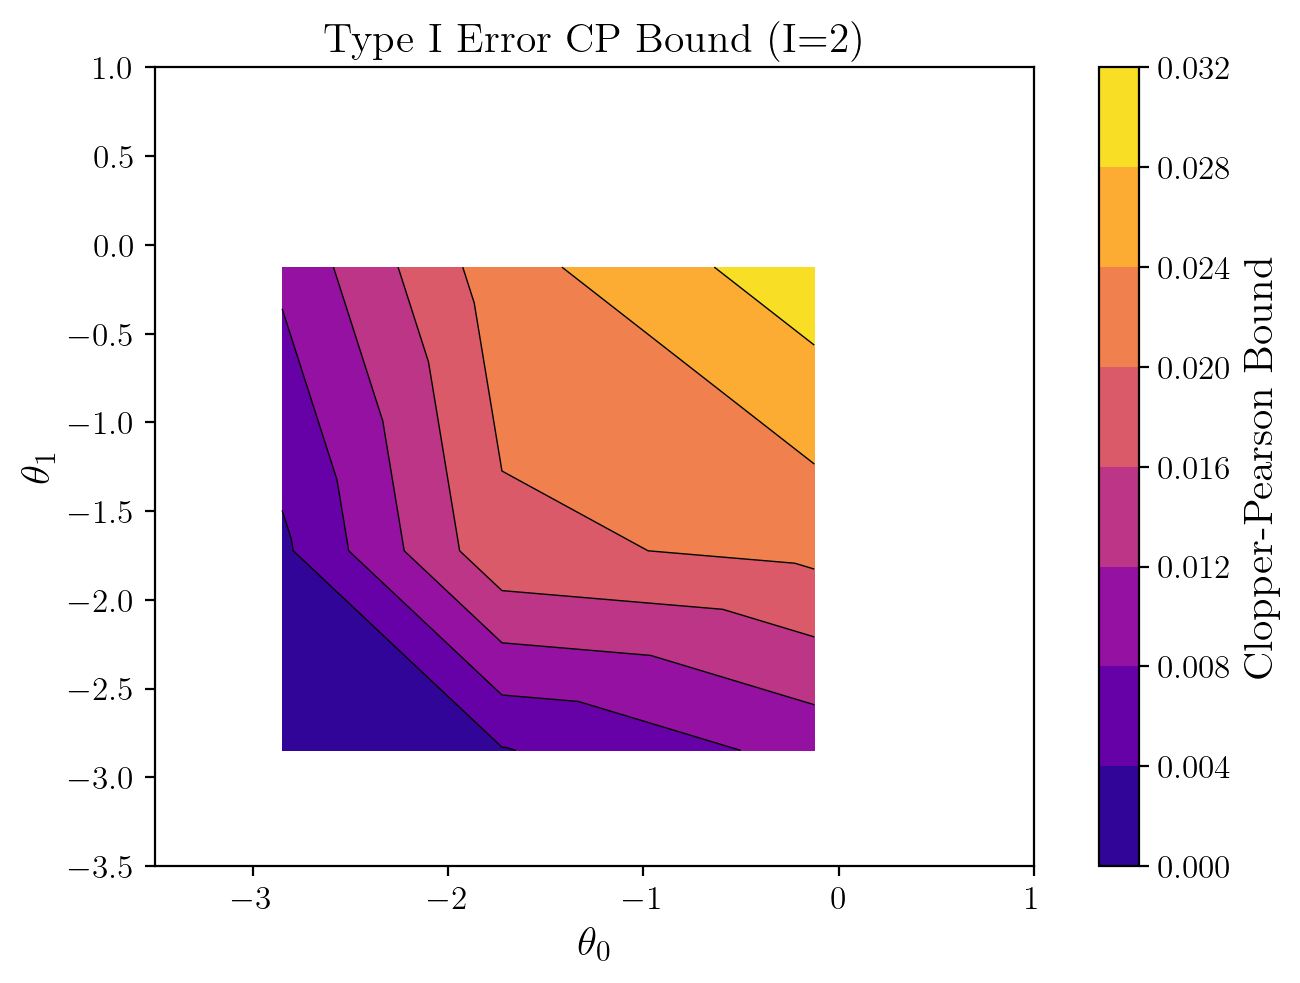

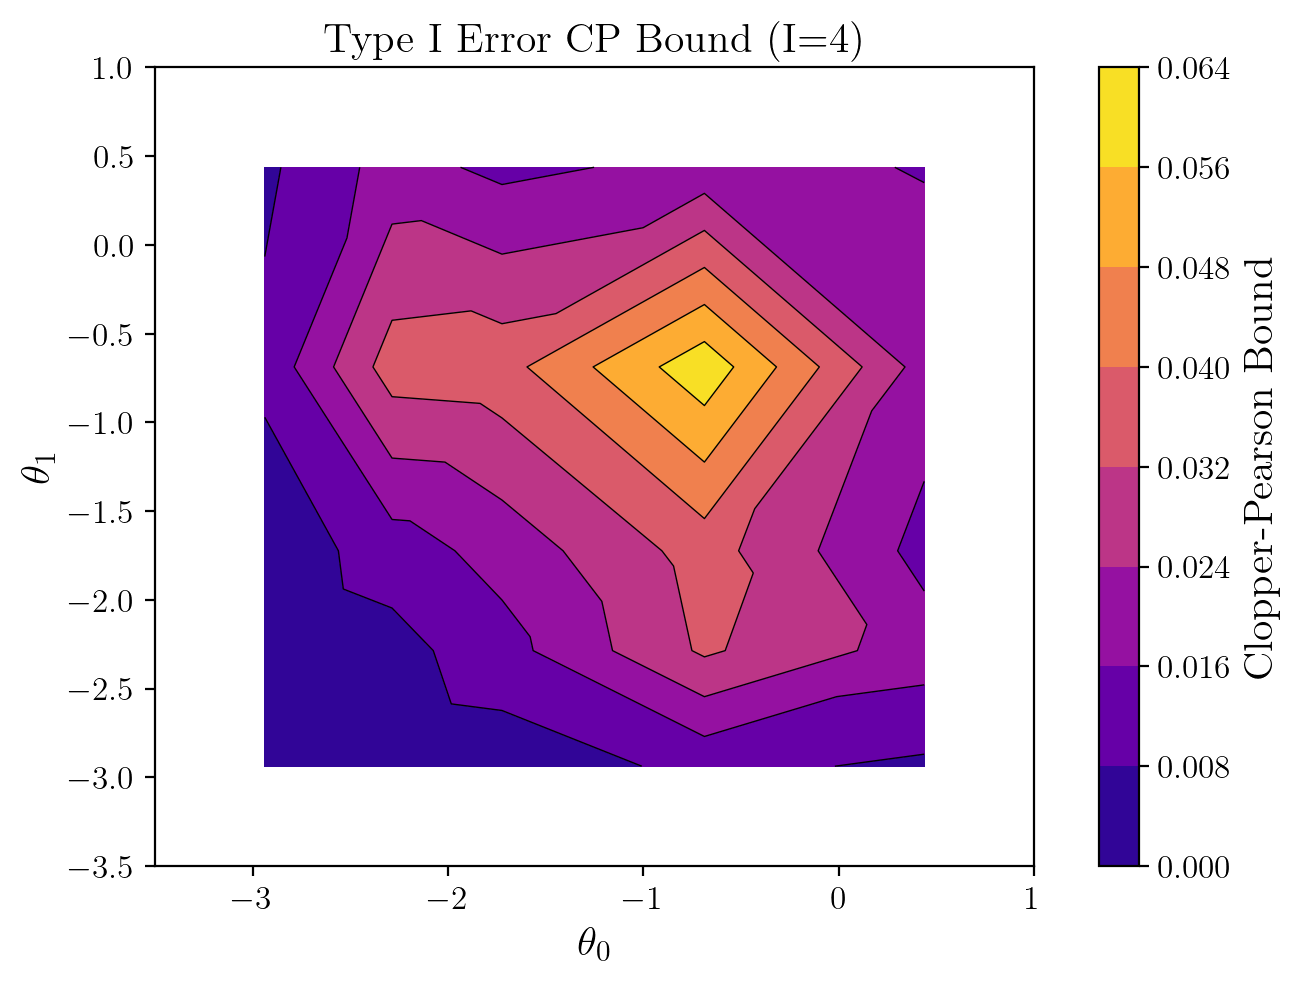

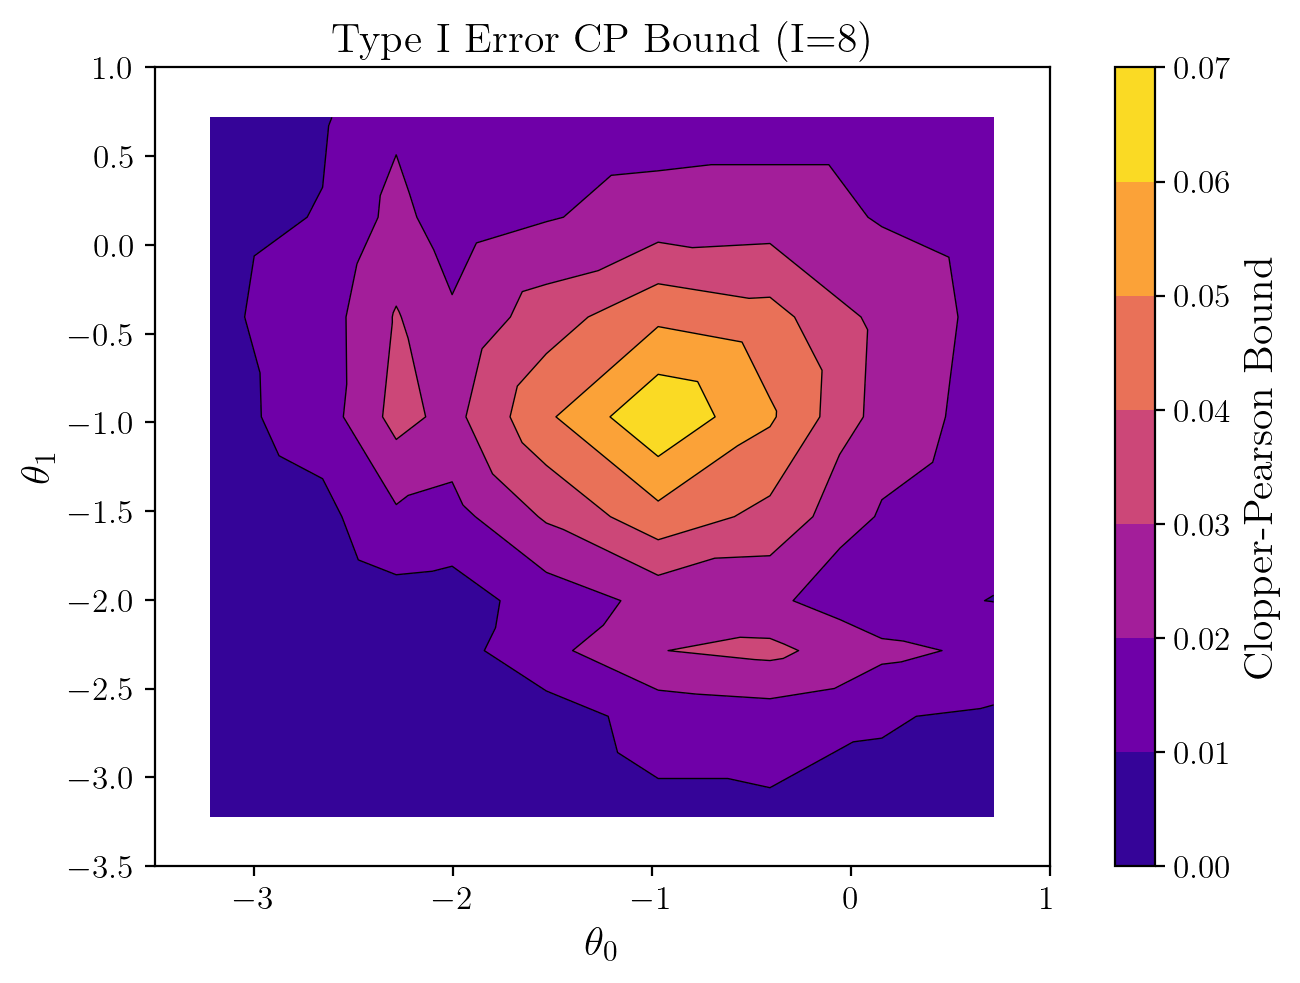

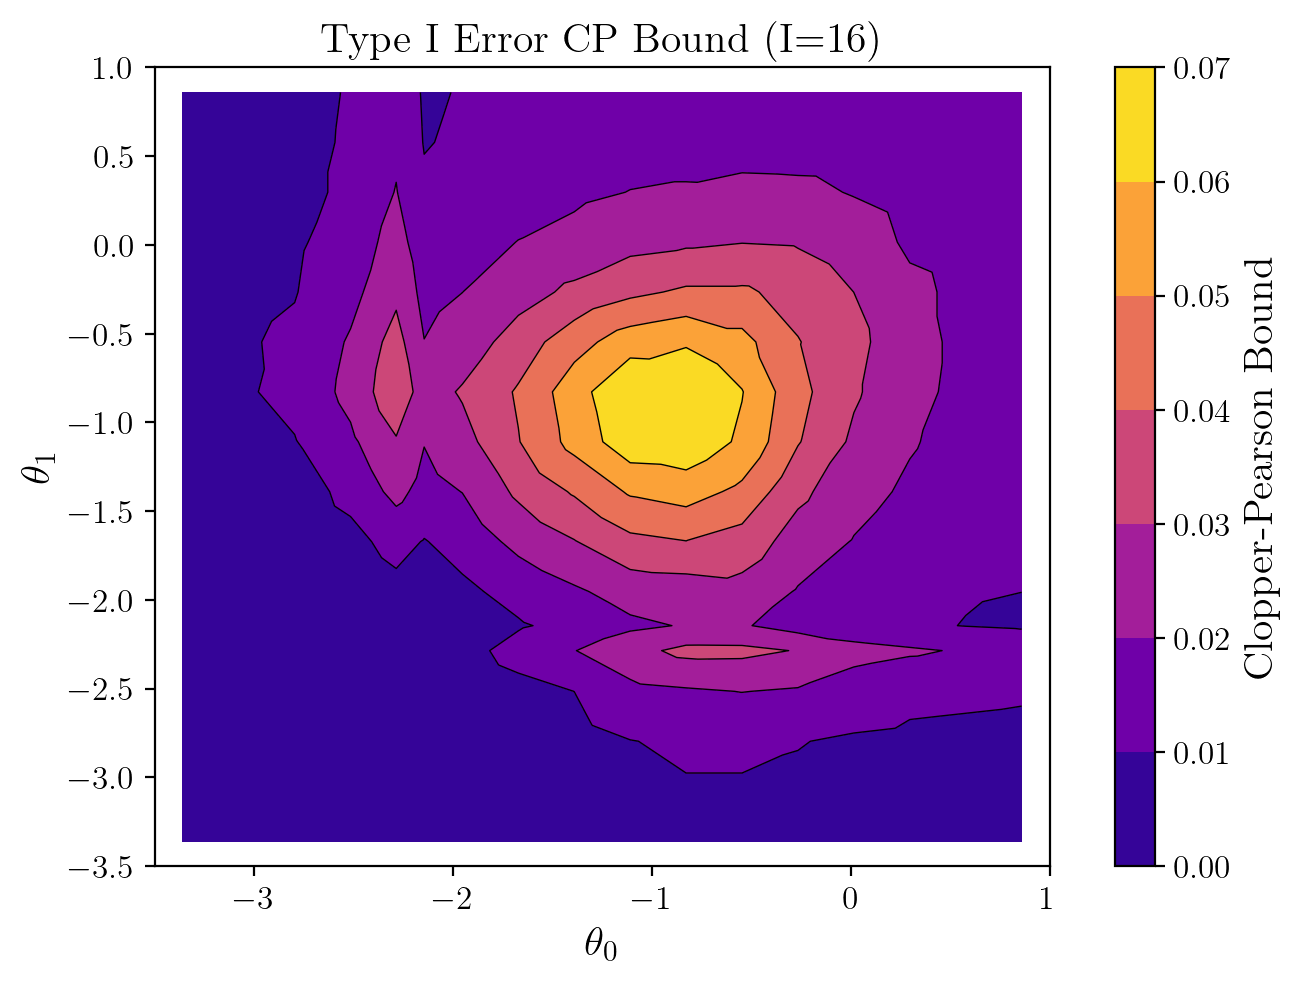

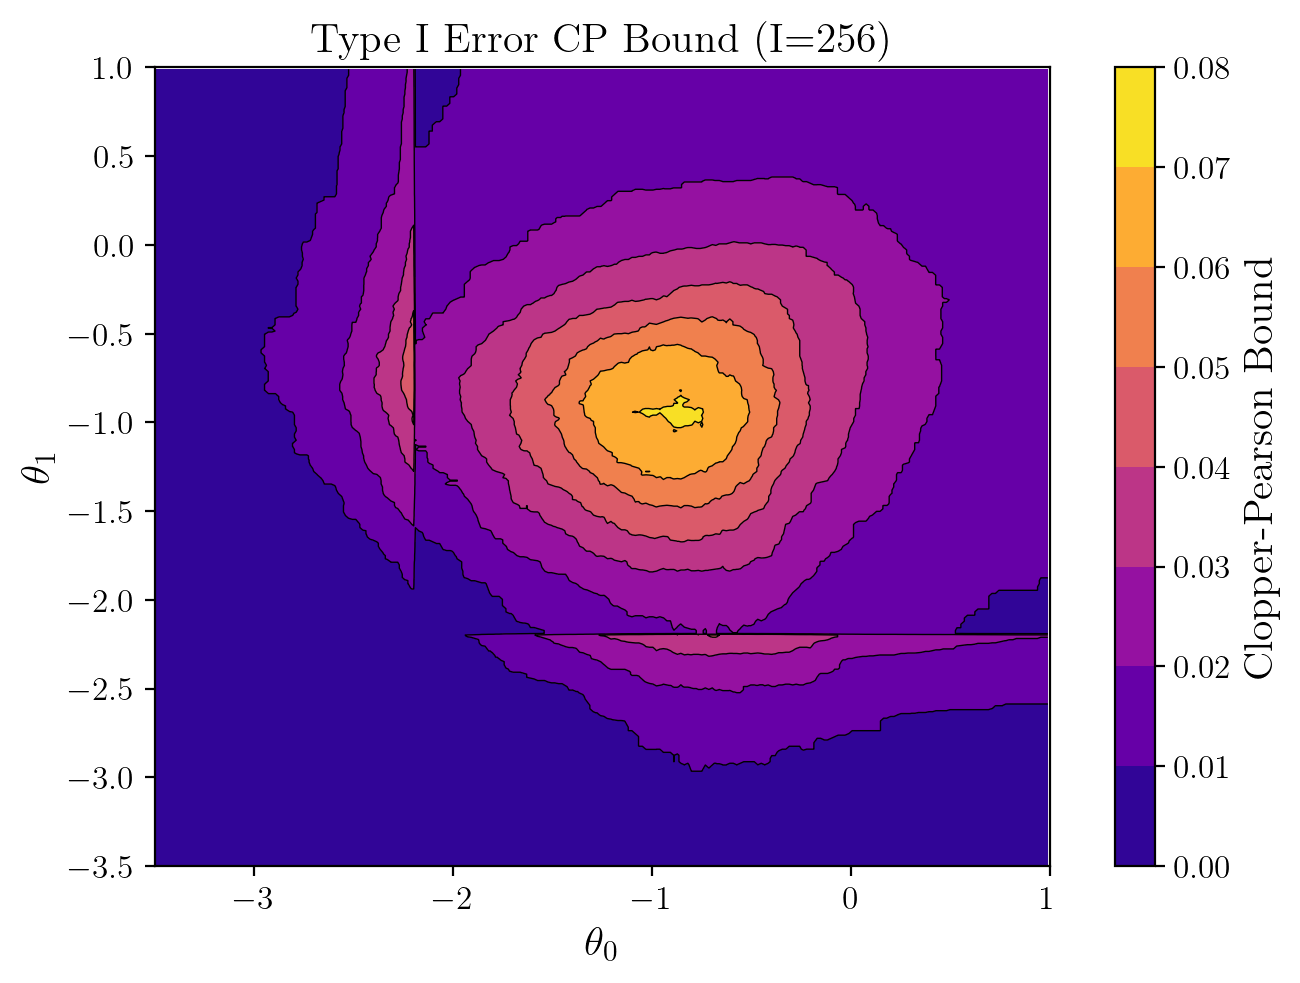

In [9]:
for i, (grid, validation_df) in enumerate(out):
    theta_tiles = grid.get_theta()

    fig = plt.figure(constrained_layout=True)
    plt.title(f"Type I Error CP Bound (I={ns[i]})")
    cntf = plt.tricontourf(
        theta_tiles[:, 0],
        theta_tiles[:, 1],
        validation_df["tie_cp_bound"],
    )
    plt.tricontour(
        theta_tiles[:, 0],
        theta_tiles[:, 1],
        validation_df["tie_cp_bound"],
        colors="k",
        linestyles="-",
        linewidths=0.5,
    )
    cbar = plt.colorbar(cntf)
    cbar.set_label("Clopper-Pearson Bound")
    plt.xlabel(r"$\theta_0$")
    plt.ylabel(r"$\theta_1$")
    plt.xlim(theta_min[0], theta_max[0])
    plt.ylim(theta_min[1], theta_max[1])
    plt.savefig(f"figures/introduction_rescue_{i}.pdf", bbox_inches='tight')
    plt.show()

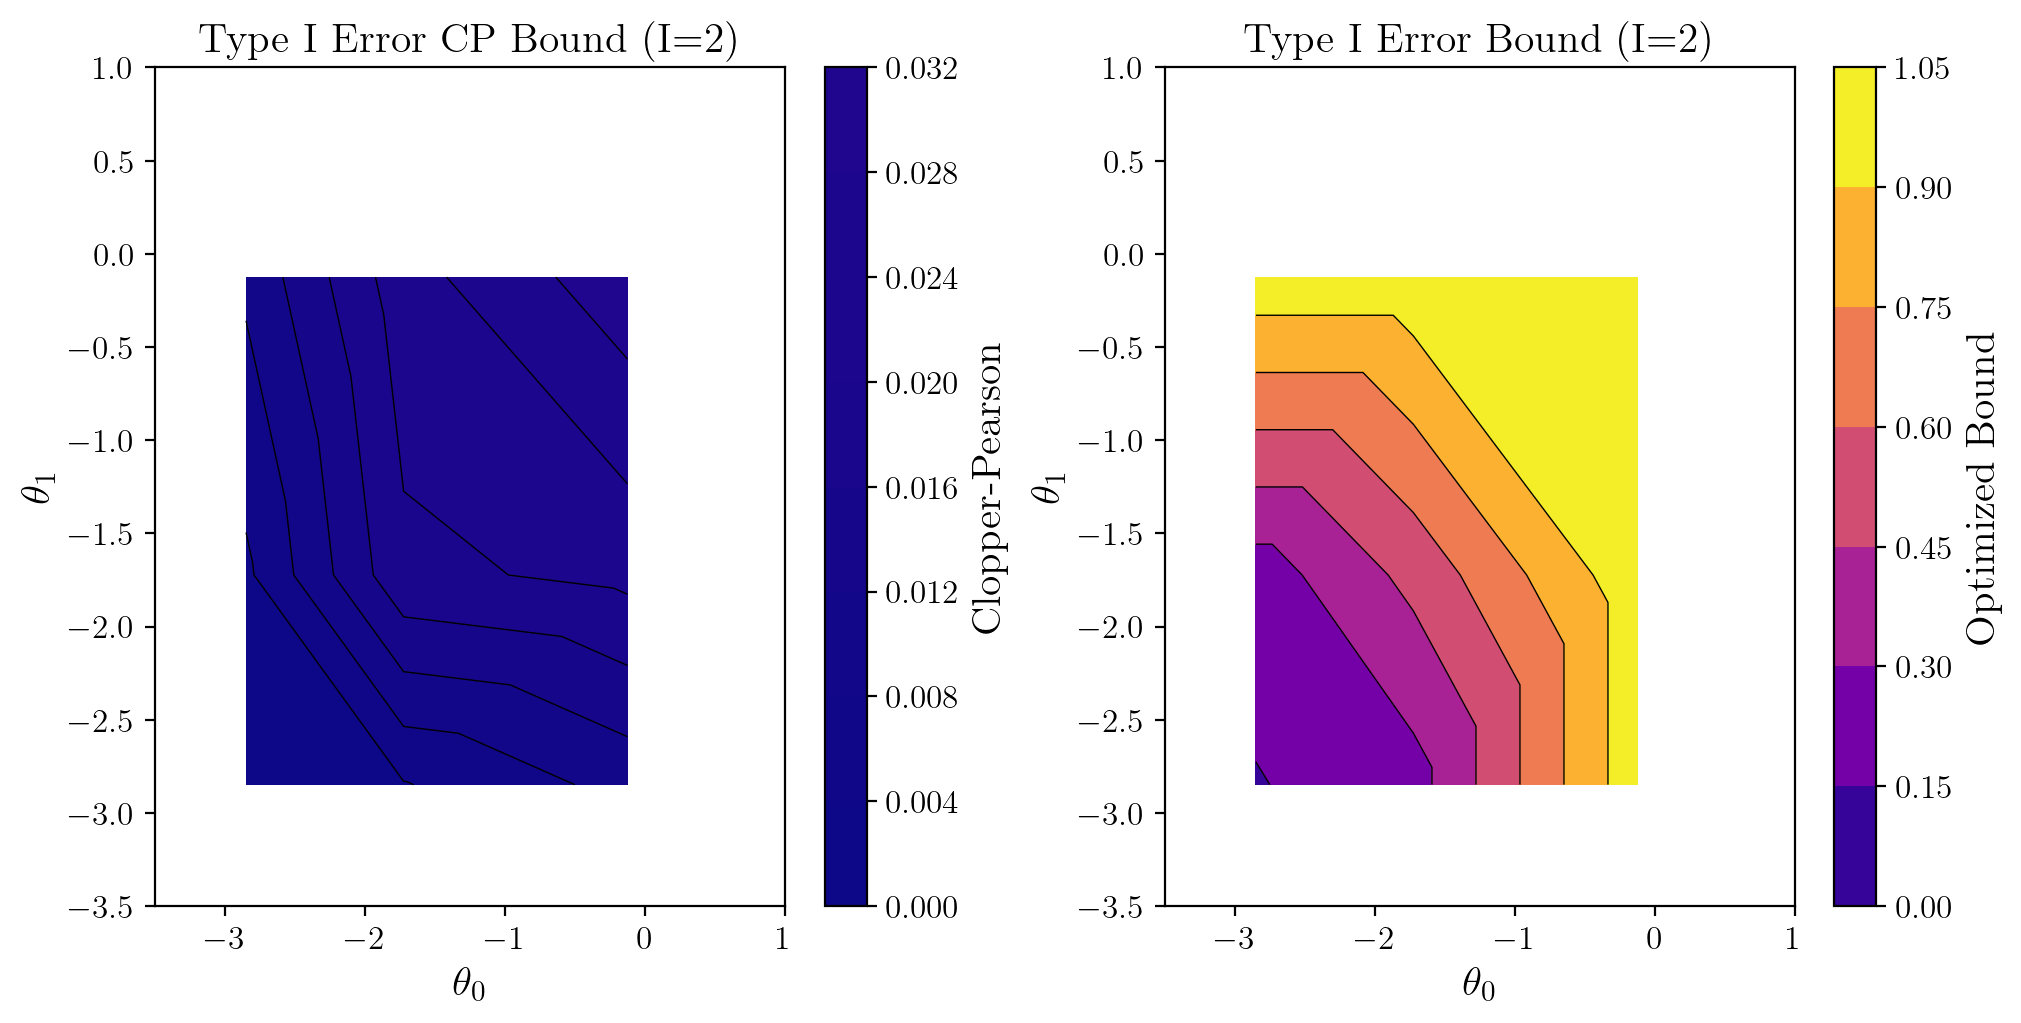

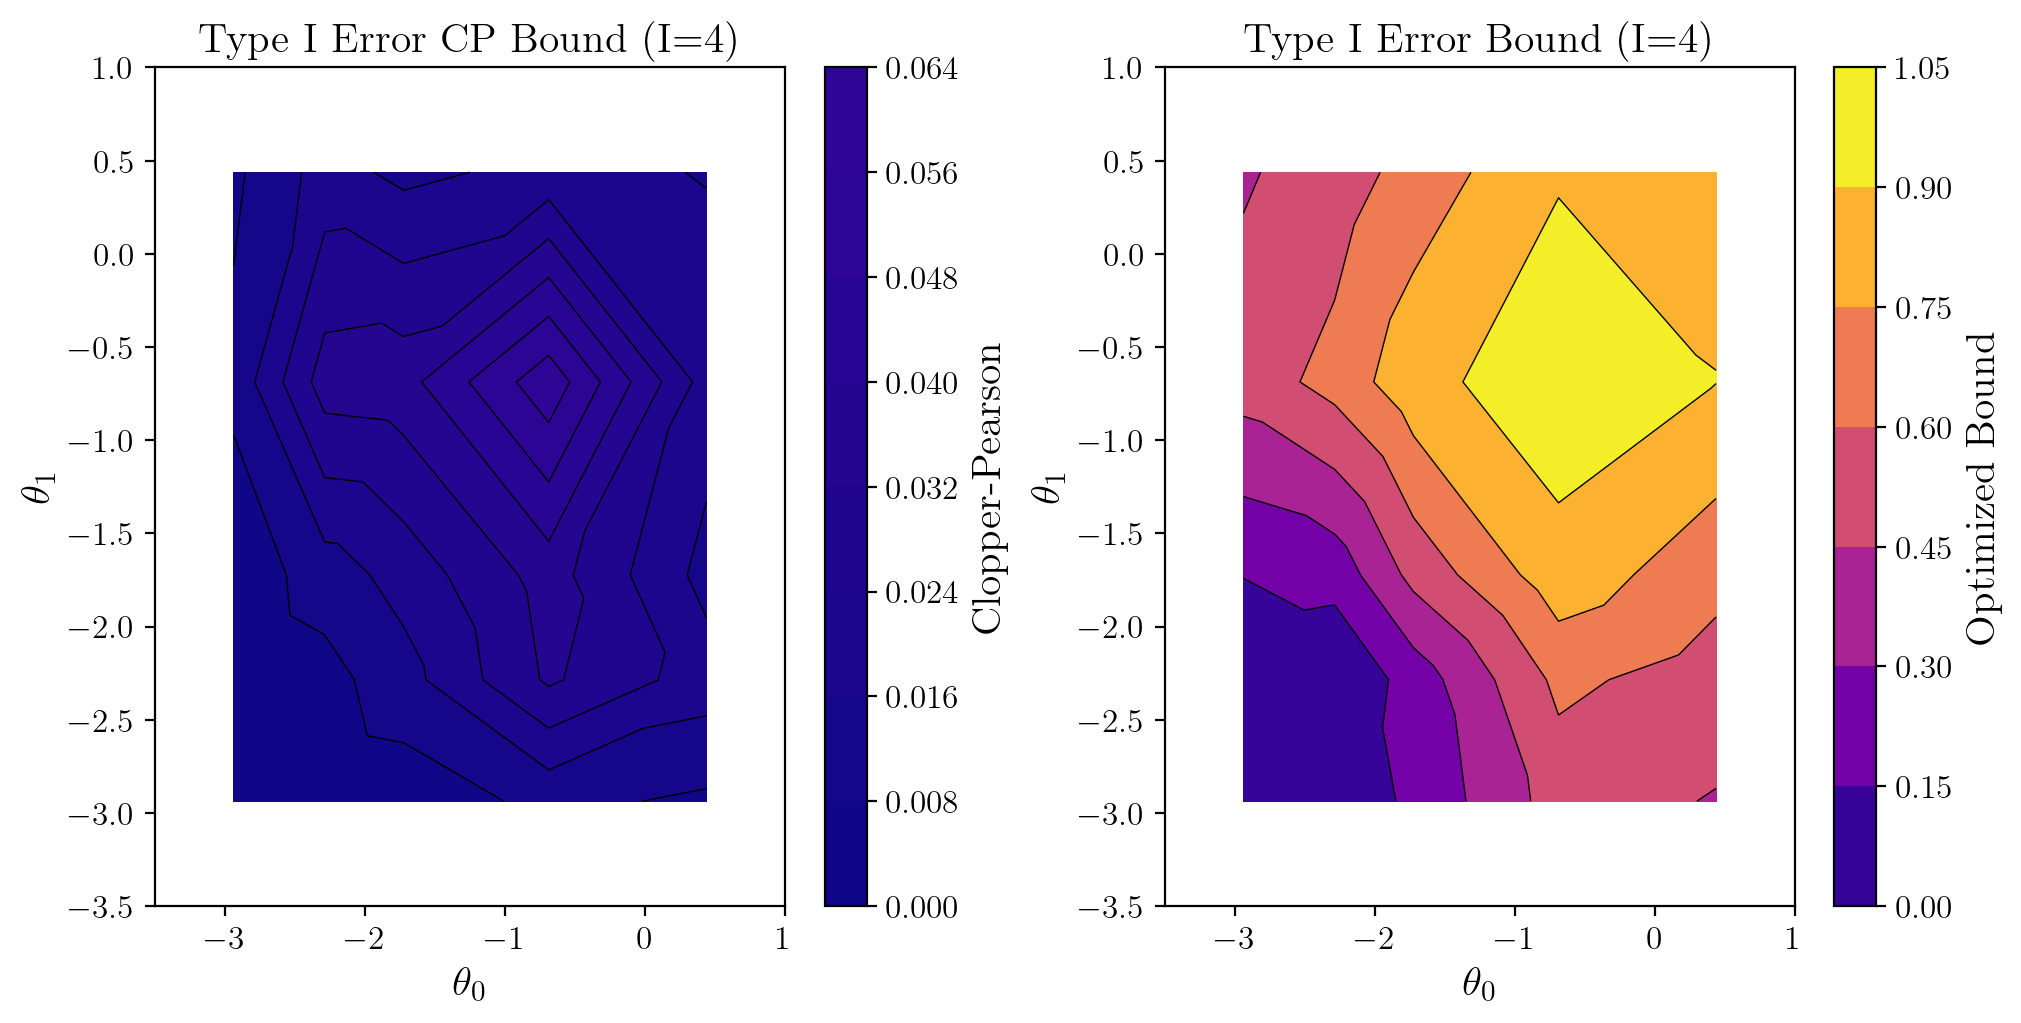

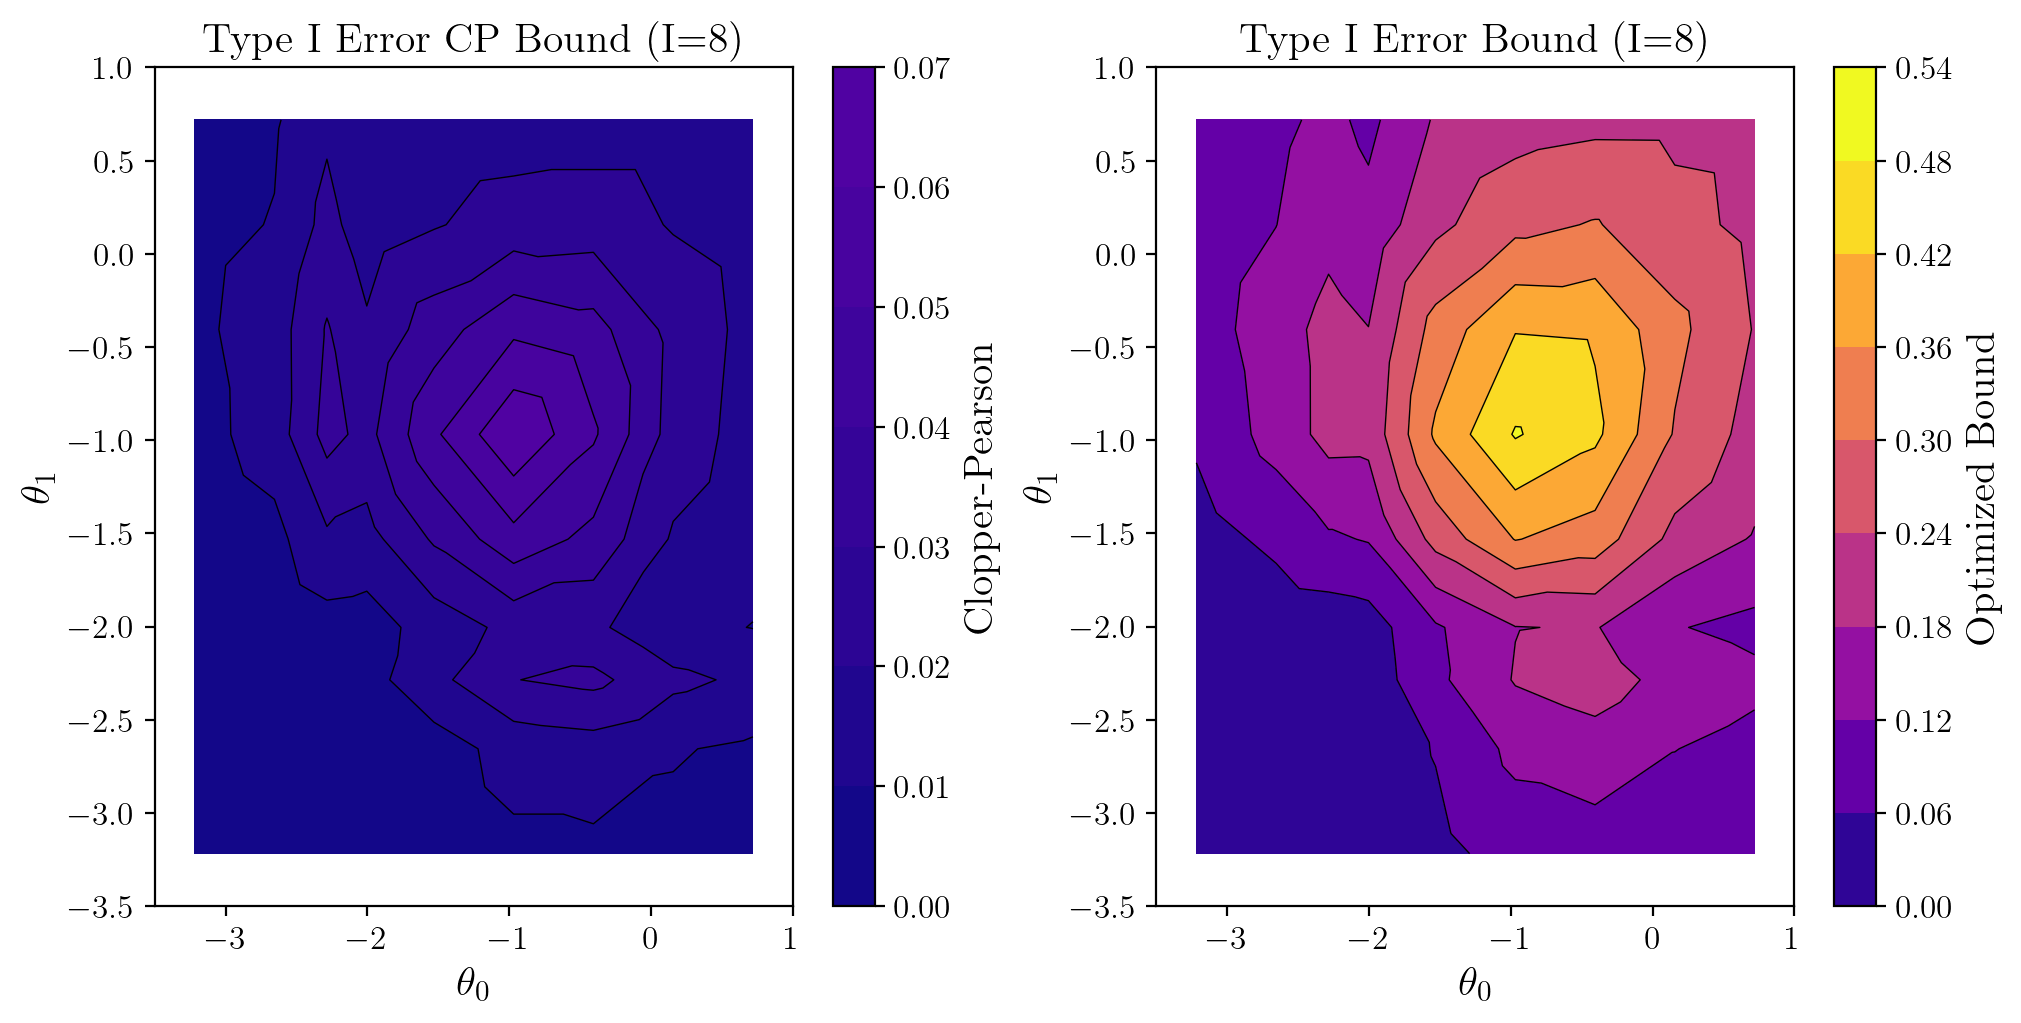

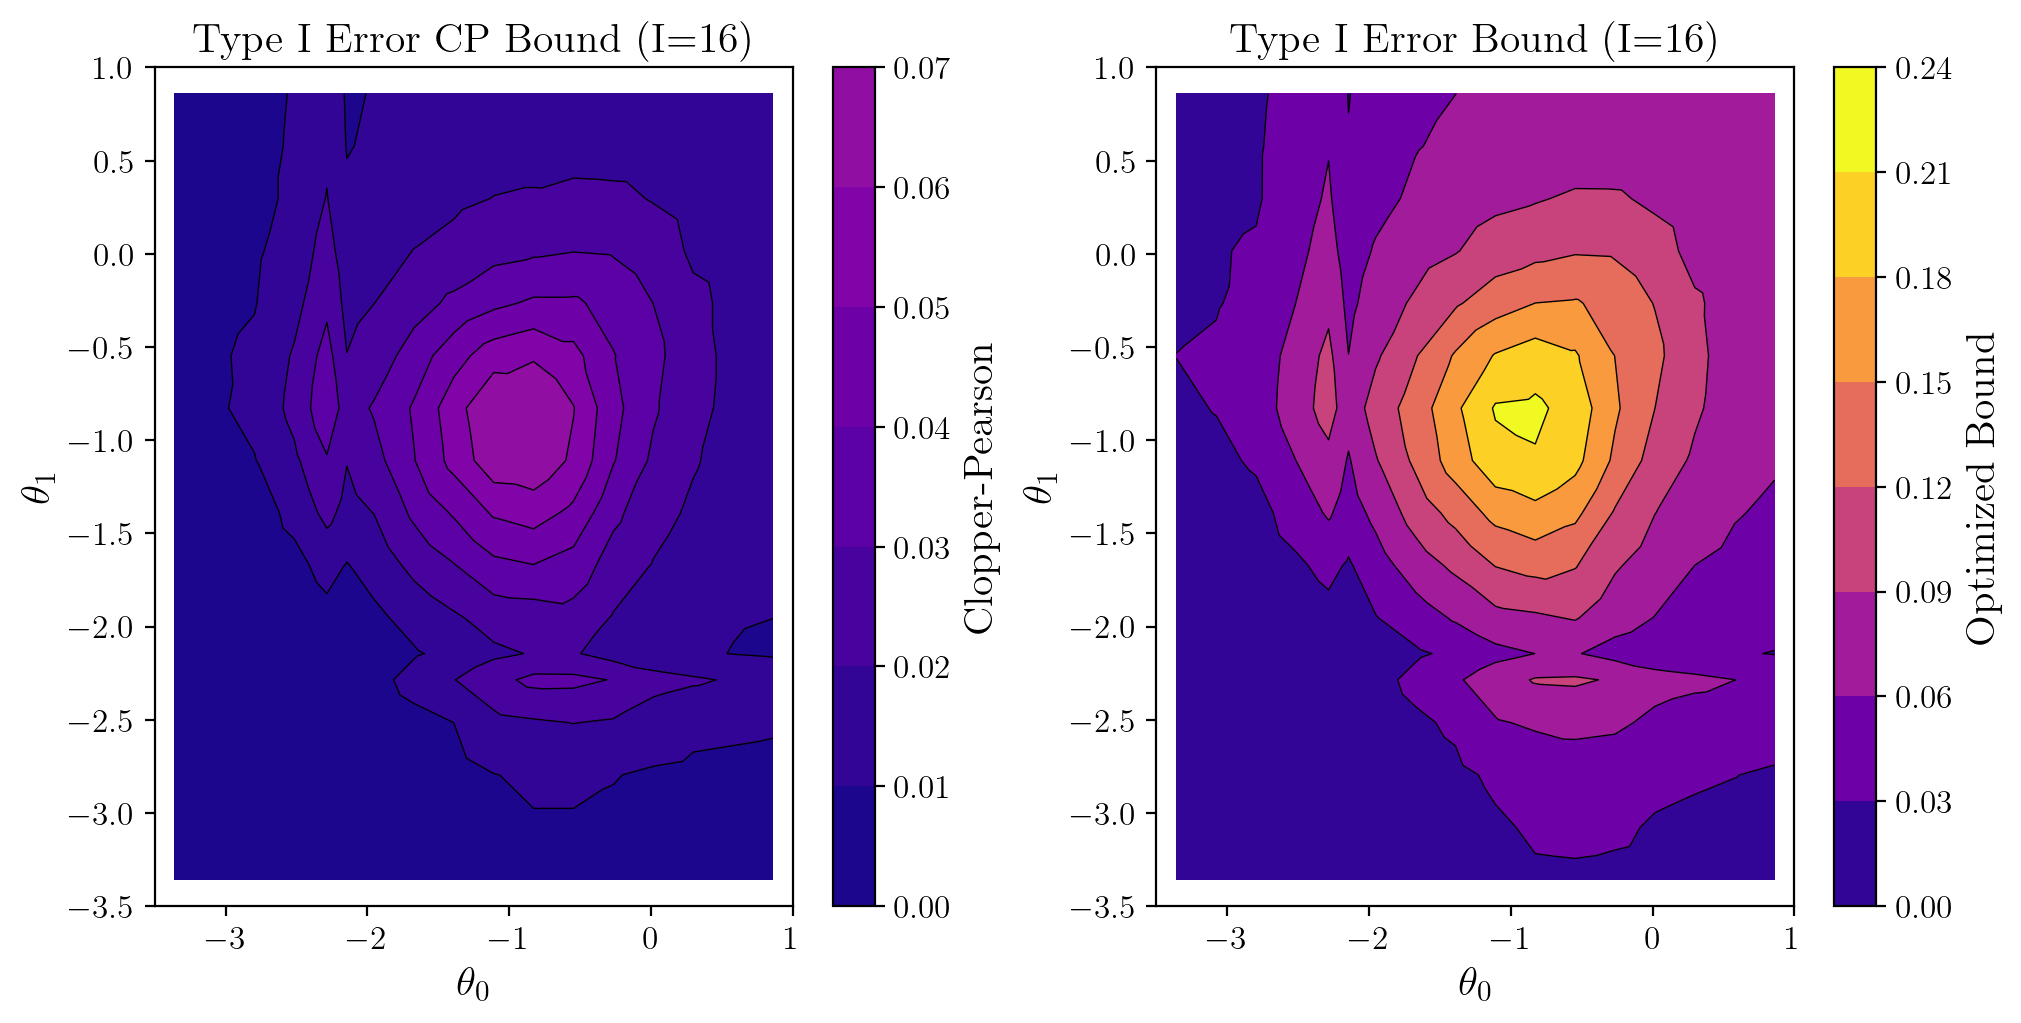

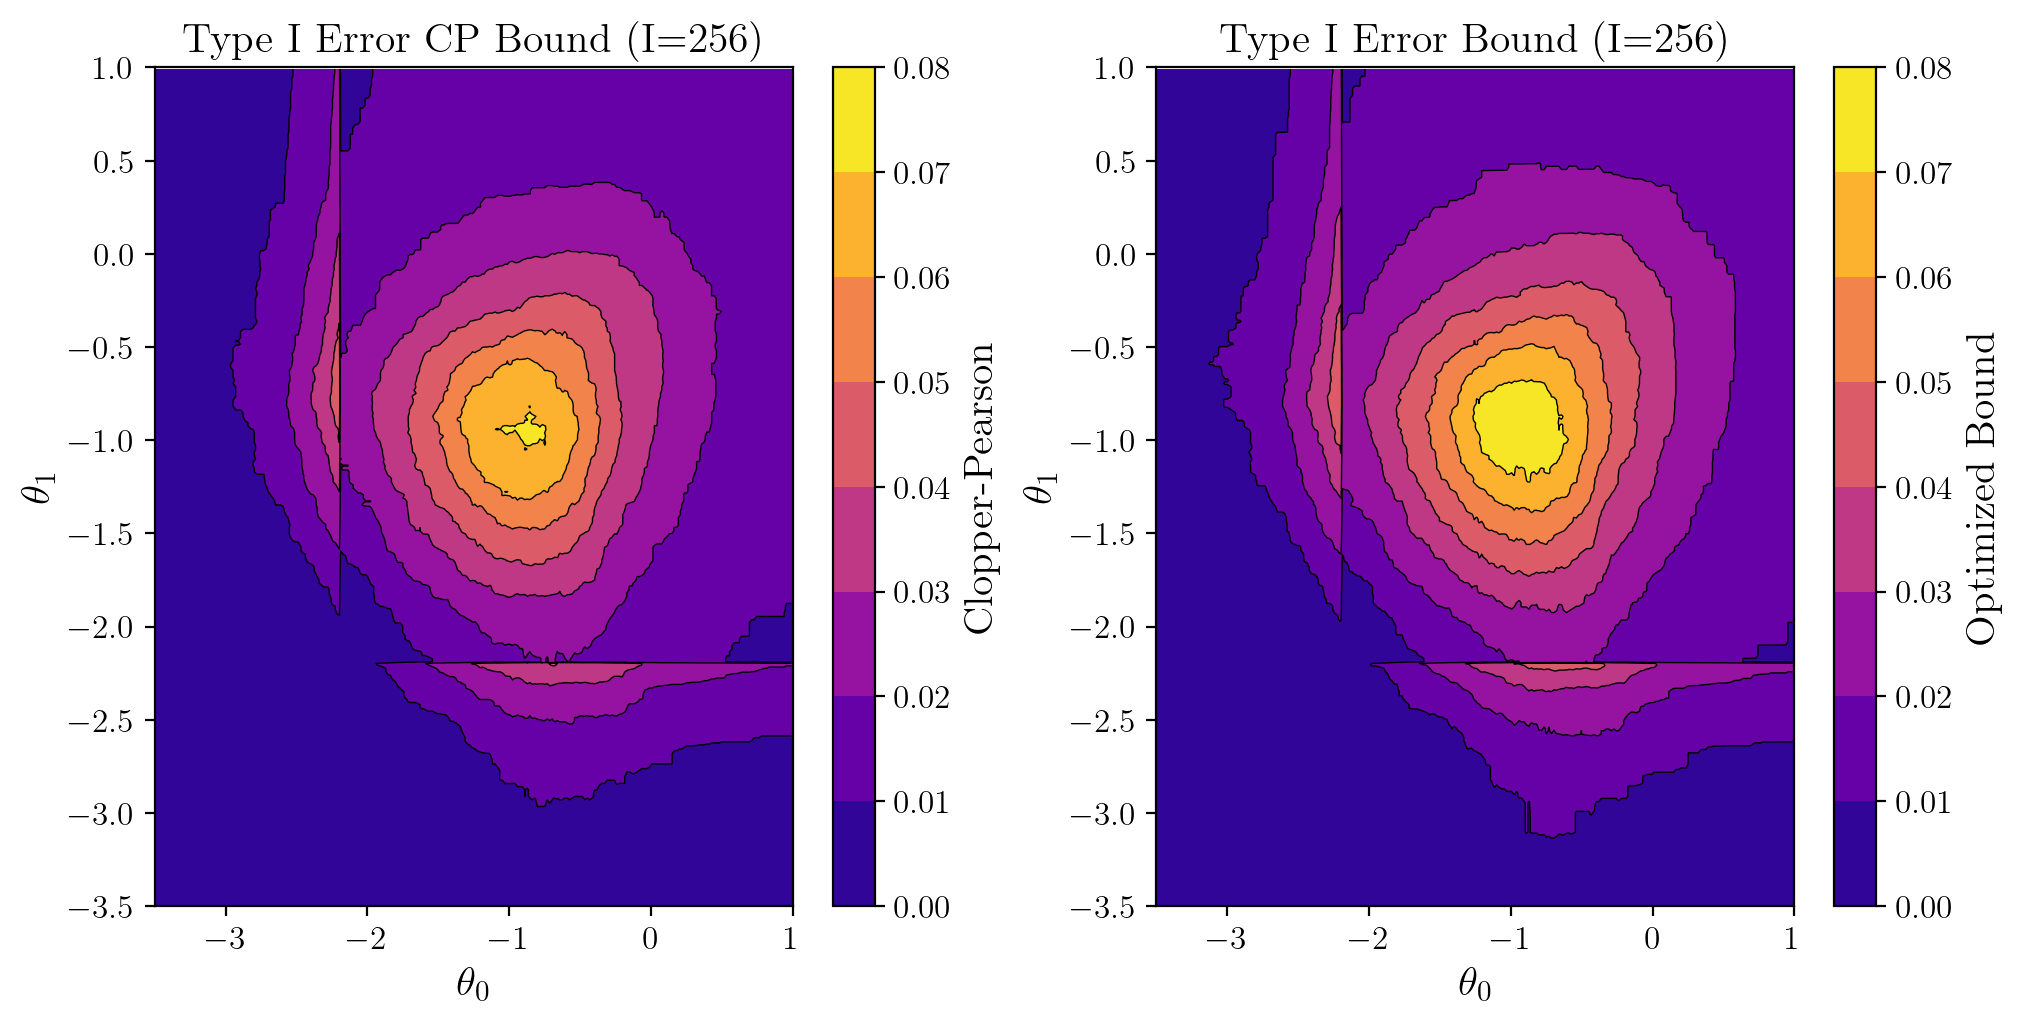

In [10]:
for i, (grid, validation_df) in enumerate(out):
    theta_tiles = grid.get_theta()
    vmax = np.max(validation_df['tie_cp_bound'])
    vmax = np.maximum(np.max(validation_df['tie_bound']), vmax)

    plt.figure(figsize=(10, 5), constrained_layout=True)
    plt.subplot(1,2,1)
    plt.title(f"Type I Error CP Bound (I={ns[i]})")
    cntf = plt.tricontourf(
        theta_tiles[:, 0],
        theta_tiles[:, 1],
        validation_df["tie_cp_bound"],
        vmax=vmax,
    )
    plt.tricontour(
        theta_tiles[:, 0],
        theta_tiles[:, 1],
        validation_df["tie_cp_bound"],
        colors="k",
        linestyles="-",
        linewidths=0.5,
        vmax=vmax,
    )
    cbar = plt.colorbar(cntf)
    cbar.set_label("Clopper-Pearson")
    plt.xlabel(r"$\theta_0$")
    plt.ylabel(r"$\theta_1$")
    plt.xlim(theta_min[0], theta_max[0])
    plt.ylim(theta_min[1], theta_max[1])

    plt.subplot(1,2,2)
    plt.title(f"Type I Error Bound (I={ns[i]})")
    cntf = plt.tricontourf(
        theta_tiles[:, 0],
        theta_tiles[:, 1],
        validation_df["tie_bound"],
        vmax=vmax,
    )
    plt.tricontour(
        theta_tiles[:, 0],
        theta_tiles[:, 1],
        validation_df["tie_bound"],
        colors="k",
        linestyles="-",
        linewidths=0.5,
        vmax=vmax,
    )
    cbar = plt.colorbar(cntf)
    cbar.set_label("Optimized Bound")
    plt.xlabel(r"$\theta_0$")
    plt.ylabel(r"$\theta_1$")
    plt.xlim(theta_min[0], theta_max[0])
    plt.ylim(theta_min[1], theta_max[1])

    plt.savefig(f"figures/berry_{i}.pdf", bbox_inches='tight')
    plt.show()